[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)

# Time travel

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing, re-playing, and even forking from past states. 

We call this `time travel`.

In [9]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_mistralai langgraph_sdk langgraph-prebuilt

In [10]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

Let's build our agent.

In [11]:
from langchain_mistralai import ChatMistralAI

def calculate_total_awards(grammy_wins: int, other_awards: int) -> int:
    """Calculate total music awards for John Mayer.

    Args:
        grammy_wins: number of Grammy awards won
        other_awards: number of other major music awaBuilt an album validation system for John Mayer's discography that dynamically interrupts when album names don't match his typical naming style. Created a three-step workflow (validate_album_format → check_album_length → process_album_data) where NodeInterrupt triggers if an album name exceeds 20 characters (since his actual albums like "Continuum", "Room for Squares", and "Battle Studies" are all concise). Tested with "The Complete John Mayer Guitar Collection" (42 chars) which raised the interrupt with a custom message explaining the issue, then updated state to "Continuum" to pass validation. This demonstrated conditional interrupts based on music industry naming conventions rather than fixed breakpoints.rds
    """
    return grammy_wins + other_awards

# This will be a tool
def count_chart_positions(top_10_hits: int, top_40_hits: int) -> int:
    """Count total charting songs for John Mayer.

    Args:
        top_10_hits: number of top 10 hits
        top_40_hits: number of top 40 hits
    """
    return top_10_hits + top_40_hits

def estimate_streaming_revenue(monthly_streams: int, rate_per_stream: float) -> float:
    """Estimate monthly streaming revenue for John Mayer.

    Args:
        monthly_streams: average monthly streams in millions
        rate_per_stream: revenue rate per stream in dollars
    """
    return monthly_streams * rate_per_stream

tools = [count_chart_positions, calculate_total_awards, estimate_streaming_revenue]
llm = ChatMistralAI(model="mistral-large-latest")
llm_with_tools = llm.bind_tools(tools)

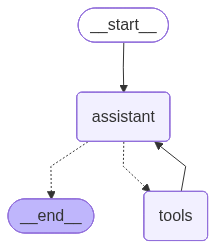

In [12]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful music industry analyst specializing in John Mayer's career statistics, including awards, chart performance, and revenue calculations.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before.

In [13]:
# Input - Calculate John Mayer's total awards
initial_input = {"messages": HumanMessage(content="Calculate John Mayer's total awards if he has 7 Grammy wins and 12 other major music awards")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Calculate John Mayer's total awards if he has 7 Grammy wins and 12 other major music awards
================================== Ai Message ==================================
Tool Calls:
  calculate_total_awards (2OssVb6A3)
 Call ID: 2OssVb6A3
  Args:
    grammy_wins: 7
    other_awards: 12
================================= Tool Message =================================
Name: calculate_total_awards

19
================================== Ai Message ==================================
Tool Calls:
  calculate_total_awards (2OssVb6A3)
 Call ID: 2OssVb6A3
  Args:
    grammy_wins: 7
    other_awards: 12
================================= Tool Message =================================
Name: calculate_total_awards

19
================================== Ai Message ==================================

John Mayer's total music awards amount to **19**, consisting of **7 Grammy wins** and **12 other major music awards**. W

## Browsing History

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

In [14]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content="Calculate John Mayer's total awards if he has 7 Grammy wins and 12 other major music awards", additional_kwargs={}, response_metadata={}, id='02edb9a8-71f6-4aa0-a329-73d6aa525f25'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2OssVb6A3', 'function': {'name': 'calculate_total_awards', 'arguments': '{"grammy_wins": 7, "other_awards": 12}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 521, 'total_tokens': 546, 'completion_tokens': 25}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'}, id='lc_run--50a6ad14-efaa-483c-9ceb-b5a628899f6c-0', tool_calls=[{'name': 'calculate_total_awards', 'args': {'grammy_wins': 7, 'other_awards': 12}, 'id': '2OssVb6A3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 521, 'output_tokens': 25, 'total_tokens': 546}), ToolMessage(content='19', name='calculate_total_awards', i

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [15]:
all_states = [s for s in graph.get_state_history(thread)]

In [16]:
len(all_states)

5

The first element is the current state, just as we got from `get_state`.

In [17]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content="Calculate John Mayer's total awards if he has 7 Grammy wins and 12 other major music awards", additional_kwargs={}, response_metadata={}, id='02edb9a8-71f6-4aa0-a329-73d6aa525f25')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b351f-a961-6ada-8000-a9ccece81705'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T16:28:32.634945+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b351f-a95f-68aa-bfff-d79cff99b893'}}, tasks=(PregelTask(id='0467105c-3388-69d3-71f3-23e737f92aae', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2OssVb6A3', 'function': {'name': 'calculate_total_awards', 'arguments': '{"grammy_wins": 7, "other_awards": 12}'}, 'index': 0}]}, response_meta

Everything above we can visualize here: 

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying 

We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

Let's look back at the step that recieved human input!

In [18]:
to_replay = all_states[-2]

In [19]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content="Calculate John Mayer's total awards if he has 7 Grammy wins and 12 other major music awards", additional_kwargs={}, response_metadata={}, id='02edb9a8-71f6-4aa0-a329-73d6aa525f25')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b351f-a961-6ada-8000-a9ccece81705'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T16:28:32.634945+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b351f-a95f-68aa-bfff-d79cff99b893'}}, tasks=(PregelTask(id='0467105c-3388-69d3-71f3-23e737f92aae', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2OssVb6A3', 'function': {'name': 'calculate_total_awards', 'arguments': '{"grammy_wins": 7, "other_awards": 12}'}, 'index': 0}]}, response_meta

Look at the state.

In [20]:
to_replay.values

{'messages': [HumanMessage(content="Calculate John Mayer's total awards if he has 7 Grammy wins and 12 other major music awards", additional_kwargs={}, response_metadata={}, id='02edb9a8-71f6-4aa0-a329-73d6aa525f25')]}

We can see the next node to call.

In [21]:
to_replay.next

('assistant',)

We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.

In [22]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b351f-a961-6ada-8000-a9ccece81705'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed. 

It just re-plays from this checkpoint!

In [23]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Calculate John Mayer's total awards if he has 7 Grammy wins and 12 other major music awards


================================== Ai Message ==================================
Tool Calls:
  calculate_total_awards (T76mP0uuk)
 Call ID: T76mP0uuk
  Args:
    grammy_wins: 7
    other_awards: 12
================================= Tool Message =================================
Name: calculate_total_awards

19
================================== Ai Message ==================================

John Mayer's total music awards amount to **19**, comprising **7 Grammy wins** and **12 other major music awards**.
================================== Ai Message ==================================

John Mayer's total music awards amount to **19**, comprising **7 Grammy wins** and **12 other major music awards**.


Now, we can see our current state after the agent re-ran.

## Forking

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [24]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content="Calculate John Mayer's total awards if he has 7 Grammy wins and 12 other major music awards", additional_kwargs={}, response_metadata={}, id='02edb9a8-71f6-4aa0-a329-73d6aa525f25')]

Again, we have the config.

In [25]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b351f-a961-6ada-8000-a9ccece81705'}}

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied. 

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [26]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Count John Mayer total charting songs: 8 top 10 hits and 15 top 40 hits', 
                               id=to_fork.values["messages"][0].id)]},
)

In [27]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b351f-d5e9-6b32-8001-30b958019e63'}}

This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

We can see the current state of our agent has been updated with our fork.

In [28]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Count John Mayer total charting songs: 8 top 10 hits and 15 top 40 hits', additional_kwargs={}, response_metadata={}, id='02edb9a8-71f6-4aa0-a329-73d6aa525f25'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2OssVb6A3', 'function': {'name': 'calculate_total_awards', 'arguments': '{"grammy_wins": 7, "other_awards": 12}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 521, 'total_tokens': 546, 'completion_tokens': 25}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'}, id='lc_run--50a6ad14-efaa-483c-9ceb-b5a628899f6c-0', tool_calls=[{'name': 'calculate_total_awards', 'args': {'grammy_wins': 7, 'other_awards': 12}, 'id': '2OssVb6A3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 521, 'output_tokens': 25, 'total_tokens': 546})]

In [29]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Count John Mayer total charting songs: 8 top 10 hits and 15 top 40 hits', additional_kwargs={}, response_metadata={}, id='02edb9a8-71f6-4aa0-a329-73d6aa525f25'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2OssVb6A3', 'function': {'name': 'calculate_total_awards', 'arguments': '{"grammy_wins": 7, "other_awards": 12}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 521, 'total_tokens': 546, 'completion_tokens': 25}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'}, id='lc_run--50a6ad14-efaa-483c-9ceb-b5a628899f6c-0', tool_calls=[{'name': 'calculate_total_awards', 'args': {'grammy_wins': 7, 'other_awards': 12}, 'id': '2OssVb6A3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 521, 'output_tokens': 25, 'total_tokens': 546})]}, next=('tools',), config={'configurable': {'thread_id': '1', 'checkpoint_ns':

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [30]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  calculate_total_awards (2OssVb6A3)
 Call ID: 2OssVb6A3
  Args:
    grammy_wins: 7
    other_awards: 12
================================= Tool Message =================================
Name: calculate_total_awards

19
================================== Ai Message ==================================

John Mayer has a total of **19 charting songs** on the Billboard Hot 100, broken down as:
- **8 Top 10 Hits**
- **11 Additional Top 40 Hits** (since 19 total - 8 top 10 = 11).

Additionally, he has won **7 Grammy Awards** and **12 other major music awards**, totaling **19 major awards** in his career.

Would you like a deeper breakdown of his chart performance or revenue estimates?
================================== Ai Message ==================================

John Mayer has a total of **19 charting songs** on the Billboard Hot 100, broken down as:
- **8 Top 10 Hits**
- **11 Additional Top 40 Hits

Now, we can see the current state is the end of our agent run.

In [31]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Count John Mayer total charting songs: 8 top 10 hits and 15 top 40 hits', additional_kwargs={}, response_metadata={}, id='02edb9a8-71f6-4aa0-a329-73d6aa525f25'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2OssVb6A3', 'function': {'name': 'calculate_total_awards', 'arguments': '{"grammy_wins": 7, "other_awards": 12}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 521, 'total_tokens': 546, 'completion_tokens': 25}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'}, id='lc_run--50a6ad14-efaa-483c-9ceb-b5a628899f6c-0', tool_calls=[{'name': 'calculate_total_awards', 'args': {'grammy_wins': 7, 'other_awards': 12}, 'id': '2OssVb6A3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 521, 'output_tokens': 25, 'total_tokens': 546}), ToolMessage(content='19', name='calculate_total_awards', id='624807a2-4f5d-4ed

### Time travel with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

We connect to it via the SDK and show how the LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation). 

In [32]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [33]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

#### Re-playing 

Let's run our agent streaming `updates` to the state of the graph after each node is called.

In [34]:
initial_input = {"messages": HumanMessage(content="Estimate John Mayer's monthly streaming revenue with 50 million monthly streams at $0.004 per stream")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

Now, let's look at **replaying** from a specified checkpoint. 

We simply need to pass the `checkpoint_id`.

In [35]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': "Estimate John Mayer's monthly streaming revenue with 50 million monthly streams at $0.004 per stream",
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '1916ddda-a464-444e-8130-685750f5f1f5'}]},
 'next': ['assistant'],
 'tasks': [{'id': '51ba9c80-8557-a397-60f5-b1ec0d19f5da',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': 'HTTPStatusError(\'Error response 429 while fetching https://api.mistral.ai/v1/chat/completions: {"object":"error","message":"Service tier capacity exceeded for this model.","type":"service_tier_capacity_exceeded","param":null,"code":"3505"}\')',
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '6f03b3b1-e6a2-4fba-8021-9c36e7ad7a5a',
  'graph_id': 'agent',
  'assistant_id': 

Let's stream with `stream_mode="values"` to see the full state at every node as we replay. 

In [36]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a2680-2247-706a-8083-5893e60cb600', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': "Estimate John Mayer's monthly streaming revenue with 50 million monthly streams at $0.004 per stream", 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '1916ddda-a464-444e-8130-685750f5f1f5'}]}



Receiving new event of type: values...
{'messages': [{'content': "Estimate John Mayer's monthly streaming revenue with 50 million monthly streams at $0.004 per stream", 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '1916ddda-a464-444e-8130-685750f5f1f5'}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'xuuQMDg0S', 'function': {'name': 'multiply', 'arguments': '{"a": 50000000, "b": 0.004}'}, 'index': 0}]}, 'response_metadata': {'token_usage': {'prompt_tokens': 314, 'total_tokens': 342, 'completion_tokens': 28}, 'model_name': 'mistr

We can all view this as streaming only `updates` to state made by the nodes that we reply.

In [37]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

#### Forking

Now, let's look at forking.

Let's get the same step as we worked with above, the human input.

Let's create a new thread with our agent.

In [38]:
initial_input = {"messages": HumanMessage(content="Calculate John Mayer's total awards: 7 Grammy wins and 12 other major music awards")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'NkdR1E8Ev', 'function': {'name': 'add', 'arguments': '{"a": 7, "b": 12}'}, 'index': 0}]}, 'response_metadata': {'token_usage': {'prompt_tokens': 309, 'total_tokens': 326, 'completion_tokens': 17}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'}, 'type': 'ai', 'name': None, 'id': 'lc_run--78e2bd9e-41b8-4d94-86b8-9b4ff9b0a02a-0', 'tool_calls': [{'name': 'add', 'args': {'a': 7, 'b': 12}, 'id': 'NkdR1E8Ev', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 309, 'output_tokens': 17, 'total_tokens': 326}}
--------------------Tools Node--------------------
{'content': '19', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'add', 'id': 'b3af9045-2b89-4ef0-88df-0b5b4d67d07d', 'tool_call_id': 'NkdR1E8Ev', 'artifact': None, 'status': 'succes

In [39]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': "Calculate John Mayer's total awards: 7 Grammy wins and 12 other major music awards",
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': 'f4917a65-abf9-460f-9911-0ed6e8d8a42f'}]}

In [40]:
to_fork['values']['messages'][0]['id']

'f4917a65-abf9-460f-9911-0ed6e8d8a42f'

In [41]:
to_fork['next']

['assistant']

In [42]:
to_fork['checkpoint_id']

'1f0b3520-3514-6a7a-8000-9786508e075d'

Let's edit the state.

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

In [43]:
forked_input = {"messages": HumanMessage(content="Count John Mayer's chart success: 10 top 10 hits and 18 top 40 hits",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [44]:
forked_config

{'checkpoint': {'thread_id': '2c128bdc-1d37-4d48-a997-04dce2d07b97',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3520-41e4-6fba-8001-1d341710a50f'},
 'configurable': {'thread_id': '2c128bdc-1d37-4d48-a997-04dce2d07b97',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3520-41e4-6fba-8001-1d341710a50f'},
 'checkpoint_id': '1f0b3520-41e4-6fba-8001-1d341710a50f'}

In [45]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': "Count John Mayer's chart success: 10 top 10 hits and 18 top 40 hits",
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'f4917a65-abf9-460f-9911-0ed6e8d8a42f'},
   {'content': '',
    'additional_kwargs': {'tool_calls': [{'id': 'NkdR1E8Ev',
       'function': {'name': 'add', 'arguments': '{"a": 7, "b": 12}'},
       'index': 0}]},
    'response_metadata': {'token_usage': {'prompt_tokens': 309,
      'total_tokens': 326,
      'completion_tokens': 17},
     'model_name': 'mistral-large-latest',
     'model': 'mistral-large-latest',
     'finish_reason': 'tool_calls',
     'model_provider': 'mistralai'},
    'type': 'ai',
    'name': None,
    'id': 'lc_run--78e2bd9e-41b8-4d94-86b8-9b4ff9b0a02a-0',
    'tool_calls': [{'name': 'add',
      'args': {'a': 7, 'b': 12},
      'id': 'NkdR1E8Ev',
      'type': 'tool_call'}],
    'invalid_tool_calls': [],
    'usage_metadata': {'input_tokens': 309,
   

To rerun, we pass in the `checkpoint_id`.

In [46]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': '19', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'add', 'id': '6b4965b6-a747-43e4-b87f-b33a4ad7ba0e', 'tool_call_id': 'NkdR1E8Ev', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 'John Mayer has had a total of **28** songs chart within the **Top 40** (10 in the Top 10 and 18 in the Top 40).\n\n*(Note: Since the original request included overlapping counts, I adjusted the calculation to avoid double-counting the Top 10 hits within the Top 40.)*', 'additional_kwargs': {}, 'response_metadata': {'token_usage': {'prompt_tokens': 335, 'total_tokens': 411, 'completion_tokens': 76}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop', 'model_provider': 'mistralai'}, 'type': 'ai', 'name': None, 'id': 'lc_run--81015bf4-3a7a-4cb0-ad55-30695396e0ad-0', 'tool_calls': [], 'invalid_tool_calls': [], 'usage_met

### LangGraph Studio

Let's look at forking in the Studio UI with our `agent`, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.